# C-SHELPh

### A notebook to use the semi-automatic retrieval of bathy photons from ICESat-2 data. You will need the bathy_utils.py script kept here: https://github.com/nmt28/C-SHELPh/blob/main/2.Bathymetry_modeling/bathy_utils.py

#### First we will need to install a list of required packages using conda or mamba:

In [2]:
try:
    import geopandas as gpd
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !conda install -c conda-forge h5py matplotlib pyproj pyproj-data geopandas utm xarray fsspec zarr

import numpy as np
import h5py as h5
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
import matplotlib.pyplot as plt
import pyproj
from pyproj import Proj
from pyproj import Transformer
import pandas as pd
import argparse
import os
import subprocess
import time
import utm
import math
import fiona
import geopandas
from datetime import datetime
# Import functions from utils.py
from bathy_utils import *
print("Packages imported")

Packages imported


#### Specify the ICESat2 ATL03 file that you want to extract bathymetry from

In [3]:
# input is2 h5 file
is2_h5_file = '/Users/nmthoma1/Downloads/processed_ATL03_20190814064755_07210401_005_01.h5'

#### ICESat2 has 6 lasers, arranged as 3 pairs of strong and weak beams. C-SHELPh only uses the strong beams.

In [12]:
# specify the laser from 1 through 3
laser_num = 3

#### Using the ReadATL03 function from bathy_utils, read in all the variables that C-SHELPh requires

In [14]:
# Read in the data
latitude, longitude, photon_h, conf, ref_elev, ref_azimuth, ph_index_beg, segment_id, alt_sc, seg_ph_count = ReadATL03(is2_h5_file, str(laser_num))

#### Find the utm zone needed for the conversion to meters (UTM)

In [17]:
# Find the epsg code
epsg_code = convert_wgs_to_utm(latitude[0], longitude[0])
epsg_num = int(epsg_code.split(':')[-1])
print(f"epsg number: {epsg_num}")

epsg number: 32616


#### Transform the IS2 data to orthometric height from WGS84 which puts the seas surface at approximately 0m elevation

In [18]:
# Orthometrically correct the data using the epsg code
lat_utm, lon_utm, photon_h = OrthometricCorrection(latitude, longitude, photon_h, epsg_code)

#### To create the most accurate models we need some detaild platform parameters which are provided as the segment (100m) and not photon scale. We first need the number of photons per segment:

In [19]:
# count number of photons in each segment
Ph_num_per_seg = seg_ph_count[ph_index_beg>0]
# Cast as an int
Ph_num_per_seg = Ph_num_per_seg.astype(np.int64)

#### Retreive platform parameters at the photon level by interpolating across the segemnts

In [20]:
Ph_ref_elev = ref_linear_interp(Ph_num_per_seg, ref_elev[ph_index_beg>0])
Ph_ref_azimuth = ref_linear_interp(Ph_num_per_seg, ref_azimuth[ph_index_beg>0])
Ph_sat_alt = ref_linear_interp(Ph_num_per_seg, alt_sc[ph_index_beg>0])

#### Make a plot of the photon reference elevation which shows the change in satellite altitude through time

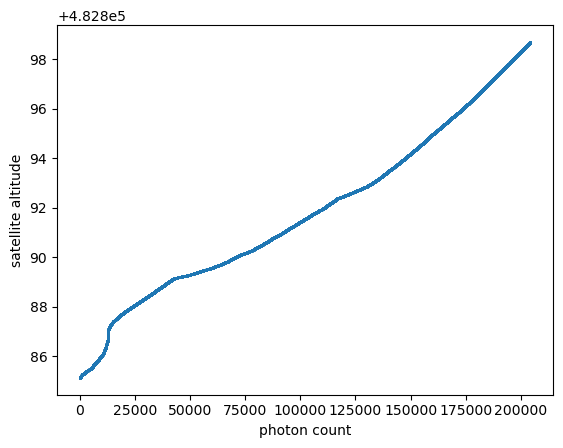

In [29]:
plt.scatter(np.arange(1,len(Ph_sat_alt)+1, 1),Ph_sat_alt,s=0.2)
plt.xlabel('photon count')
plt.ylabel('satellite altitude')
plt.show()

#### The next step is to pull all of our required data into a dataframe for processing

In [31]:
# Aggregate data into dataframe
dataset_sea = pd.DataFrame({'latitude': lat_utm, 'longitude': lon_utm, 'photon_height': photon_h, 'confidence':conf, 'ref_elevation':Ph_ref_elev, 'ref_azminuth':Ph_ref_azimuth, 'ref_sat_alt':Ph_sat_alt}, 
                       columns=['latitude', 'longitude', 'photon_height', 'confidence', 'ref_elevation', 'ref_azminuth', 'ref_sat_alt'])

#### At this point, we can check out our data and see what it looks like

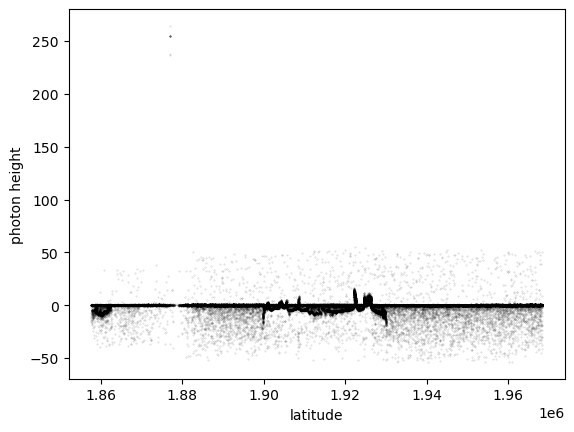

In [34]:
plt.scatter(dataset_sea['latitude'],dataset_sea['photon_height'],c='black', s=0.1, alpha=0.2)
plt.xlabel('latitude')
plt.ylabel('photon height')
plt.show()

#### There are photon heights here that are well above our range of interest and a lot more photons than are necessary becaus eof noise. We can filter these values out

In [36]:
print('filter quality flags')
dataset_sea1 = dataset_sea[(dataset_sea.confidence != 0)  & (dataset_sea.confidence != 1)]
# Filter for elevation range
print('filter for elevation')
dataset_sea1 = dataset_sea1[(dataset_sea1['photon_height'] > -40) & (dataset_sea1['photon_height'] < 5)]

filter quality flags
filter for elevation


#### Now when we plot this we should be able to see our dataset more clearly

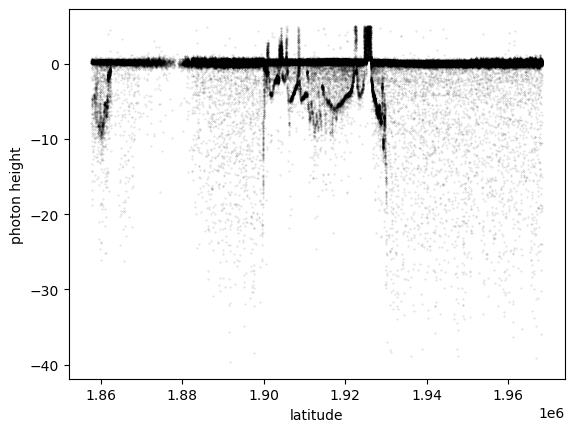

In [37]:
plt.clf()
plt.scatter(dataset_sea1['latitude'],dataset_sea1['photon_height'],c='black', s=0.1, alpha=0.2)
plt.xlabel('latitude')
plt.ylabel('photon height')
plt.show()

#### Now we have our data ready we can bin the data in 2-dimensions so that we can calculate the density of the photons in each bin. For this we need to specify the bin height and width in m

In [40]:
# set along track bin width to 10 m
lat_res = 10
# set vertical bin resolution to 0.5 m
h_res = 0.5 

In [41]:
binned_data_sea = bin_data(dataset_sea1, lat_res, h_res)

#### The next step finds the most densley populated bins near the surface of the water (assumed to be around 0) where the photons are classified as the sea surface. A single median value is taken as the sea surface height.

In [43]:
sea_height = get_sea_height(binned_data_sea)
WSHeight = np.nanmedian(sea_height)

In [46]:
print(f'The median sea surface height is: {WSHeight}')

The median sea surface height is: 0.21797676122863896


#### One important step in retrieving bathymetric heights is performing a refraction correction which is induced when the photon eneters the water. This refraction provides a false photon location and depth value so needs to be corrected for. One important parameter of this correction is water temperature.

#### We can automatically retrieve a water temperature estimate using  the MUR SST dataset hosted on AW: https://registry.opendata.aws/mur/

In [49]:
print('Fetching water temperature...')
waterTemp = get_water_temp(is2_h5_file, latitude, longitude)     
print(f"water temp: {waterTemp} deg C")

Fetching water temperature...
water temp: 30.61 deg C


#### Now we have the parameters needed for the refraction correction we can perform this. Additional parameters needed here are the laser wavelength which is 532 nm for ICESat2. Another is water salinity and refraction correction coefficients which are set in bathy_utils. These coefficients are taken from here: https://research.engr.oregonstate.edu/parrish/index-refraction-seawater-and-freshwater-function-wavelength-and-temperature#overlay-context=research

In [53]:
wavelength = 532

RefX, RefY, RefZ, RefConf, rawX, rawY, rawZ, ph_ref_azi, ph_ref_elev = RefractionCorrection(waterTemp, WSHeight, wavelength, dataset_sea1.ref_elevation, dataset_sea1.ref_azminuth, dataset_sea1.photon_height, dataset_sea1.longitude, dataset_sea1.latitude, dataset_sea1.confidence, dataset_sea1.ref_sat_alt)
print('Refraction correction completed')

Refraction correction completed


#### Now to find the depths we substitute our depths (RefZ) from our sea surface height

In [55]:
# Find bathy depth
depth = WSHeight - RefZ

#### Now we can create a dataframe with our new refraction corrected data

In [60]:
# Create new dataframe with refraction corrected data
dataset_bath = pd.DataFrame({'latitude': rawY, 'longitude': rawX, 'cor_latitude':RefY, 'cor_longitude':RefX, 'cor_photon_height':RefZ, 'photon_height': rawZ, 'confidence':RefConf, 'depth':depth}, 
                       columns=['latitude', 'longitude', 'photon_height', 'cor_latitude','cor_longitude', 'cor_photon_height', 'confidence', 'depth'])
dataset_bath

,latitude,longitude,photon_height,cor_latitude,cor_longitude,cor_photon_height,confidence,depth
1,1.857621e+06,410957.231901,0.078381,1.857621e+06,410957.233406,0.113779,4,0.104198
3,1.857623e+06,410957.112008,0.141469,1.857623e+06,410957.112833,0.160869,4,0.057107
4,1.857629e+06,410956.563866,0.044149,1.857629e+06,410956.565741,0.088227,4,0.129749
5,1.857629e+06,410956.563288,0.020385,1.857629e+06,410956.565419,0.070489,4,0.147487
8,1.857634e+06,410956.095962,-1.770523,1.857634e+06,410956.117406,-1.266289,3,1.484266
...,...,...,...,...,...,...,...,...
204306,1.968298e+06,400511.125923,0.108207,1.968298e+06,400511.127097,0.136042,4,0.081935
204307,1.968298e+06,400511.125273,0.081259,1.968298e+06,400511.126735,0.115928,4,0.102049
204308,1.968299e+06,400511.046509,-0.077396,1.968299e+06,400511.049667,-0.002497,4,0.220473
204309,1.968300e+06,400510.901892,0.141402,1.968300e+06,400510.902711,0.160820,4,0.057157


#### We need to bin the dataset again now that the valyes have changed

In [61]:
# Bin dataset again for bathymetry
binned_data = bin_data(dataset_bath, lat_res, h_res)

#### Now we can use the density of the photons in each bin to locate surfaces. An important parameter here is the threshold parameter. This is a percentile value which helps separate noise from data. Sue to the high sensitivity of ICESat2, all bins will have photons even when there is no bathy surface as photons reflect off of particles in the water column. To avoid false positives being recorded, we use a threshold value. You can vary this value and see how the selection changes.

In [68]:
threshold = 30 #(0-100)
bath_height, geo_df = get_bath_height(binned_data, threshold, WSHeight, h_res)

#### Now we can plot the data to see how well our threshold value performed

(-20.0, 5.0)

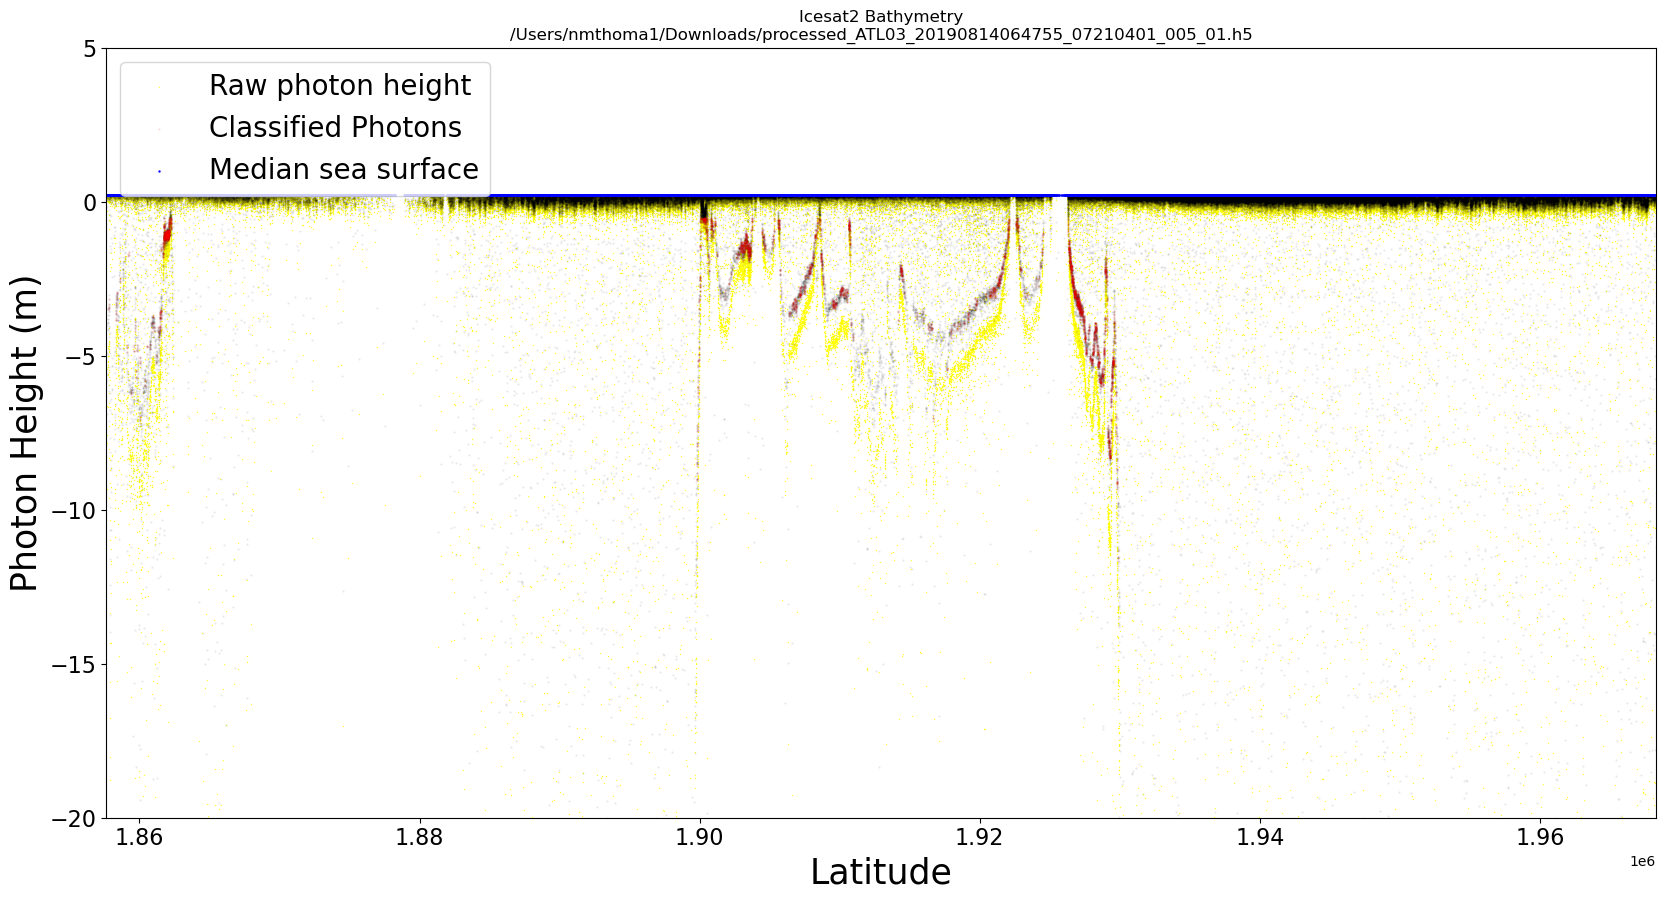

In [73]:
# Create bins for latitude
x_bins = np.linspace(binned_data.latitude.min(), binned_data.latitude.max(), len(sea_height))

# Create new dataframes for median values  
bath_median_df = pd.DataFrame.from_dict({'x' : x_bins ,'y' : bath_height}, orient='index')
bath_median_df = bath_median_df.transpose()


# Create uniform sea surface based on median sea surface values and filter out surface breaching
sea_surf = [np.nanmedian(sea_height) if i == i else np.nan for i in sea_height]
sea_median_df = pd.DataFrame({'x':x_bins, 'y':sea_surf})

# Define figure size
fig = plt.rcParams["figure.figsize"] = (20,10)

# Plot raw points
plt.scatter(x=binned_data.latitude, y = binned_data.photon_height, marker='o', lw=0, s=1, alpha = 0.8, c = 'yellow', label ='Raw photon height')
plt.scatter(RefY, RefZ, s=0.2, alpha=0.1, c='black')
plt.scatter(geo_df.latitude, geo_df.photon_height, s=0.5, alpha=0.1, c='red', label = 'Classified Photons')

plt.scatter(sea_median_df.x, sea_median_df.y, marker = 'o', c='b', alpha = 1, s = 0.5, label = 'Median sea surface')

# Insert titles and sub-titles
plt.title('Icesat2 Bathymetry\n' + is2_h5_file)
plt.xlabel('Latitude', fontsize=25)
plt.ylabel('Photon Height (m)', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc="upper left",prop={'size': 20})

# Limit the x and y axes using parameters
plt.xlim(left=binned_data.latitude.min(), right=binned_data.latitude.max())
plt.ylim(top = 5, bottom = -20)

#### Here we are trying to color the dense black photons in red, without coloring in the sparse black photons. This is where the threshold value needs to be tailored for the optimum result.

#### The yellow photons are the original non-refraction ciorrected photons